<a href="https://colab.research.google.com/github/SantiDrelewicz/Aprendizaje-Automatico/blob/main/AA-II/notebooks/notebook_13_intro_a_llms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a Modelos de Lenguajes


## I. ELMO [opcional]

En el procesamiento de lenguaje natural (NLP), los modelos de lenguaje tradicionales como Word2Vec o GloVe representan cada palabra con un vector fijo, independientemente del contexto en el que aparece. Por ejemplo, la palabra "banco" tendrá el mismo embedding ya sea en "banco suizo” o "banco de la plaza", lo cual limita la capacidad del modelo para capturar ambigüedades léxicas.

ELMo (Embeddings from Language Models) propone una solución a esto utilizando un enfoque contextual basado en redes neuronales recurrentes bidireccionales (BiLSTM). En lugar de asignar un único vector por palabra, ELMo genera **representaciones dinámicas** que dependen del contexto completo de la oración. El input son embeddings estáticos y el output embeddings contextuales. El modelo está pre-entrenado pero puede ser fine-tuneado para tareas específicas.


### Ejercicio: Explorando ELMo vs. GloVe

En este ejercicio compararemos dos tipos de representaciones semánticas:
-	GloVe: embeddings estáticos (preentrenados, independientes del contexto).
-	ELMo: embeddings contextuales (preentrenados, dependientes del contexto).


1.	Descargar  los vectores GloVe.
2.	Utilizar TensorFlow Hub para cargar el modelo preentrenado de ELMo.
3.	Comparar cómo se representa una palabra ambigua (ej: bank) en distintos contextos.
4.	Visualizar los embeddings usando reducción de dimensionalidad (PCA o t-SNE).

In [ ]:
!pip install  -q tensorflow tensorflow_hub

import tensorflow as tf
import tensorflow_hub as hub # desgargamos elmo de tensorflow_hub
import numpy as np
import spacy # para procesar texto

nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

In [ ]:
%%capture download_glove_vectors
!wget http://nlp.stanford.edu/data/glove.6B.zip --no-check-certificate
!unzip glove.6B.zip

In [ ]:
# print(download_glove_vectors)

In [ ]:
def load_glove_vectors(filename):
    embeddings = {}
    with open(filename, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_vectors('glove.6B.100d.txt')

In [ ]:
def get_glove_embedding(word):
    return glove_embeddings.get(word, np.zeros((100,)))

In [ ]:
elmo_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=False, output_key='elmo', signature='tokens')

In [ ]:
def get_elmo_embedding(sentence, target_word=None):
    doc = nlp(sentence)
    tokens = [token.text for token in doc]

    if target_word is not None:
      idx = tokens.index(target_word)

    tokens_tensor = tf.convert_to_tensor([tokens])
    sequence_len_tensor = tf.convert_to_tensor([len(tokens)])

    embeddings = elmo_layer(inputs={'tokens': tokens_tensor, 'sequence_len': sequence_len_tensor})

    if target_word is not None:
      return embeddings.numpy()[0][idx]
    else:
      return embeddings.numpy()

In [ ]:
word = "apple"
print("GloVe embedding for 'apple':", get_glove_embedding(word))
print("ELMo embedding for 'apple':", get_elmo_embedding("Apple is a fruit")[0])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_contextual_embeddings(sentences, target_word):
    glove_embedding = get_glove_embedding(target_word)
    elmo_embeddings = [get_elmo_embedding(sentence, target_word) for sentence in sentences]

    glove_embeddings = [glove_embedding for _ in sentences]

    pca_glove = PCA(n_components=2)
    glove_2d = pca_glove.fit_transform(glove_embeddings)

    pca_elmo = PCA(n_components=2)
    elmo_2d = pca_elmo.fit_transform(elmo_embeddings)

    plt.figure(figsize=(10, 5))

    for i, sentence in enumerate(sentences):
        plt.scatter(glove_2d[i, 0], glove_2d[i, 1], color='blue', label='GloVe' if i == 0 else "")
        plt.text(glove_2d[i, 0], glove_2d[i, 1], sentence, fontsize=9, color='blue')

        plt.scatter(elmo_2d[i, 0], elmo_2d[i, 1], color='red', label='ELMo' if i == 0 else "")
        plt.text(elmo_2d[i, 0], elmo_2d[i, 1], sentence, fontsize=9, color='red')

    plt.legend()
    plt.title(f"2D PCA of GloVe and ELMo embeddings for the word '{target_word}'")
    plt.show()

In [ ]:
contextual_sentences = [
    "I deposited money in the bank.",
    "The boat drifted to the bank of the river.",
    "We rested for a while on a wooden bank in the park.",
    "Central bank printed money recklessly.",
    "A bank in the pub.",
]

visualize_contextual_embeddings(contextual_sentences, "bank")

¿Qué observa?

> Su respuesta

## II. Self-Attention

Adaptado de: https://colab.research.google.com/drive/1rPk3ohrmVclqhH7uQ7qys4oznDdAhpzF#scrollTo=oavQirdbhAK7

En esta sección vamos a impelementar el mecanismo de self-attention visto en la clase teórica.

¿Qué hace *self-attention*? El mecanismo de self-attention permite que cada vector de entrada en una secuencia “preste atención” a todos los demás (incluido a sí mismo) para construir una representación contextualizada.

Dado un conjunto de vectores de entrada $\mathbf{x}_1, \dots, \mathbf{x}_n \in \mathbb{R}^d$, el mecanismo produce vectores de salida $\mathbf{z}_1, \dots, \mathbf{z}_n \in \mathbb{R}^{d’}$, donde cada salida $\mathbf{z}_i$ es una combinación ponderada de todos los valores en la secuencia.

Veamos cómo funciona paso a paso.

In [ ]:
import torch

Dado $\mathbf{X} \in \mathbb{R}^{n \times d}$, se proyectan las entradas a tres espacios distintos:
- Queries: $\mathbf{Q} = \mathbf{XW}^Q$
- Keys: $\mathbf{K} = \mathbf{XW}^K$
- Values: $\mathbf{V} = \mathbf{XW}^V$

donde $\mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V \in \mathbb{R}^{d \times d’}$ son matrices de pesos aprendibles.

1. Consideremos un caso simple donde tenemos 3 vectores de $d=3$.


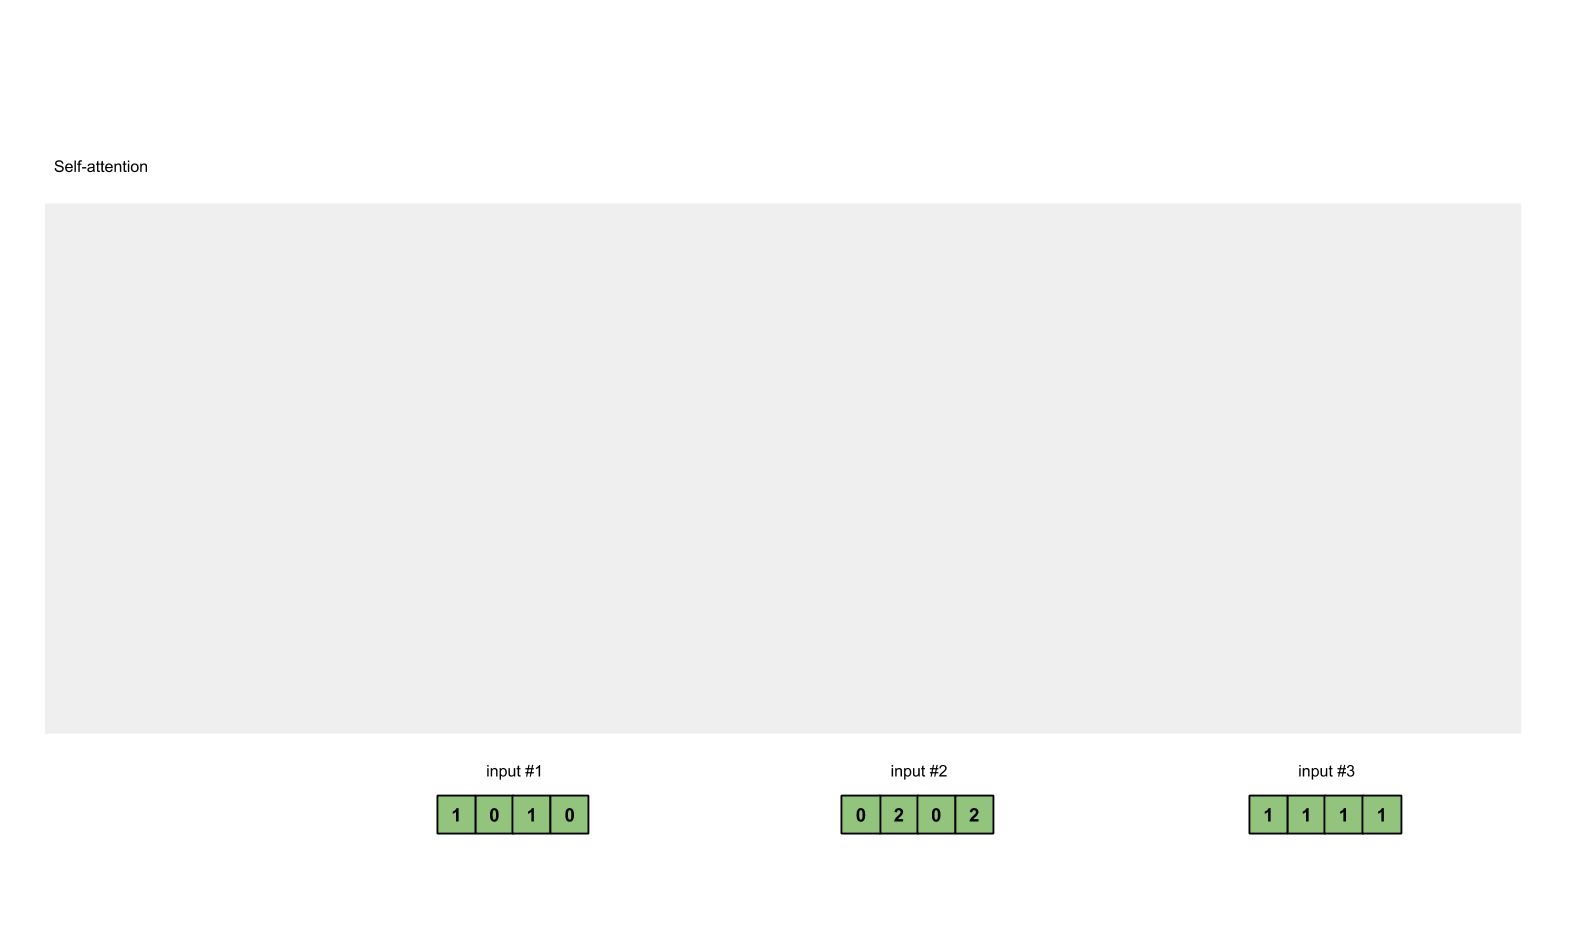

In [ ]:
# 1. Definir el input
x = [
  [1, 0, 1, 0], # Input 1
  # Continuar ...
 ]
x = torch.tensor(x, dtype=torch.float32)
x

2. Cada vector tiene tres representaciones $k_i, q_i, v_i$ que se obtienen al multiplicar el vector de entrada por la matriz de peso correspondiente. En este caso usaremos una matriz de peso fija, pero en una red neuronal, estos se inicializan aleatoriamente (sampleando de distribución gaussiana, inicialización Xavier o Kaiming).

Ejemplo: para obtener los `keys`, calculamos
```
               [0, 0, 1]
[1, 0, 1, 0]   [1, 1, 0]   [0, 1, 1]
[0, 2, 0, 2] x [0, 1, 0] = [4, 4, 0]
[1, 1, 1, 1]   [1, 1, 0]   [2, 3, 1]
```


![texto del enlace](https://miro.medium.com/max/1975/1*VPvXYMGjv0kRuoYqgFvCag.gif)

In [ ]:
# 2.1. Definir los pesos, los consideraremos fijos
w_key = [
  [0, 0, 1],
  [1, 1, 0],
  [0, 1, 0],
  [1, 1, 0]
]
w_query = [
  [1, 0, 1],
  [1, 0, 0],
  [0, 0, 1],
  [0, 1, 1]
]
w_value = [
  [0, 2, 0],
  [0, 3, 0],
  [1, 0, 3],
  [1, 1, 0]
]
w_key = torch.tensor(w_key, dtype=torch.float32)
w_query = torch.tensor(w_query, dtype=torch.float32)
w_value = torch.tensor(w_value, dtype=torch.float32)

print("Weights for key: \n", w_key)
print("Weights for query: \n", w_query)
print("Weights for value: \n", w_value)

In [ ]:
# 2.2 Calculamos k_i, v_i, q_i

keys = # TODO
querys = #TODO
values = #TODO

print("Keys: \n", keys)
# RTA:
# tensor([[0., 1., 1.],
#         [4., 4., 0.],
#         [2., 3., 1.]])

print("Querys: \n", querys)
# RTA:
# tensor([[1., 0., 2.],
#         [2., 2., 2.],
#         [2., 1., 3.]])
print("Values: \n", values)
# RTA:
# tensor([[1., 2., 3.],
#         [2., 8., 0.],
#         [2., 6., 3.]])

Una vez que proyectamos $\mathbf{X}$ en los espacios de $\mathbf{K, Q, V}$, podemos calcular el attention score, dado por el producto punto entre cada query y todas las keys:
$$
\text{Scores} = \mathbf{Q} \mathbf{K}^\top
$$

3. Veamos cómo lo calculamos en nuestro ejemplo. Para obtener los *scores de attention*, tomamos el primer `query` (rojo) y todos los `keys` (naranja), incluído a sí mismo; y computamos el producto punto entre cada uno:
```
               [0, 4, 2]
[1, 0, 2] x [1, 4, 3] = [2, 4, 4]
               [1, 0, 1]
```
  ![texto alternativo](https://miro.medium.com/max/1973/1*u27nhUppoWYIGkRDmYFN2A.gif)

Este procedimiento se repite para todos los queries.

Nota: *La operación anterior se conoce como dot-product attention, una de varias funciones de attention. Otras funciones de attention incluyen el scaled-dot-product y la función aditiva (o de concatenación).*            

In [ ]:
# 3. Calculamos attention score

attn_scores = #TODO
print(attn_scores)

# tensor([[ 2.,  4.,  4.],  # attention scores from Query 1
#         [ 4., 16., 12.],  # attention scores from Query 2
#         [ 4., 12., 10.]]) # attention scores from Query 3

Los siguientes pasos son:
- **Normalización**. Se aplica la función softmax para convertir los scores en probabilidades:
$$
\mathbf{A} = \text{softmax}(\mathbf{QK}^\top)
$$
- **Ponderación**. Se multiplica cada vector de atención por los values para obtener los valores ponderados:
$$
\mathbf{Z} = \mathbf{A} \mathbf{V}
$$
donde $\mathbf{A}$ es la matriz de atención, donde cada fila $\mathbf{A}_i$ contiene los pesos softmax que indica cuánta atención debería prestar la entrada $i$ a todas las otras entradas $j$ de la fila.

4. Cómputo de softmax. Si consideramos el primer vector $x_1$, el *softmax* para los attention score obtenidos se computa de la siguiente forma:
```
softmax([2, 4, 4]) = [0.0, 0.5, 0.5]
```
![texto alternativo](https://miro.medium.com/max/1973/1*jf__2D8RNCzefwS0TP1Kyg.gif)

In [ ]:
# 4. Computar softmax para todos los ejemplos
from torch.nn.functional import softmax

attn_scores_softmax = # TODO
print(attn_scores_softmax)

# tensor([[6.3379e-02, 4.6831e-01, 4.6831e-01],
#         [6.0337e-06, 9.8201e-01, 1.7986e-02],
#         [2.9539e-04, 8.8054e-01, 1.1917e-01]])

# Para poder leerlo más fácil, usemos estos valores.
attn_scores_softmax = [
  [0.0, 0.5, 0.5],
  [0.0, 1.0, 0.0],
  [0.0, 0.9, 0.1]
]
attn_scores_softmax = torch.tensor(attn_scores_softmax)
print(attn_scores_softmax)
print(attn_scores_softmax.shape)

5. Ponderamos los *values* con los score de attention normalizados para obtener values ponderados $z_i$.
Veamos un ejemplo primero con $x_1$. ![texto alternativo](https://miro.medium.com/max/1973/1*9cTaJGgXPbiJ4AOCc6QHyA.gif)
Los attention scores luego del softmax para cada input (azul) son multiplicados con sus respectivos *values* (violeta). Esto resulta en tres vectores ponderados (amarillo):
```
1: 0.0 * [1, 2, 3] = [0.0, 0.0, 0.0]
2: 0.5 * [2, 8, 0] = [1.0, 4.0, 0.0]
3: 0.5 * [2, 6, 3] = [1.0, 3.0, 1.5]
```
Luego, tomamos estos tres vectores ponderados y los sumamos:
![texto alternativo](https://miro.medium.com/max/1973/1*1je5TwhVAwwnIeDFvww3ew.gif)

  ```
     [0.0, 0.0, 0.0]
  + [1.0, 4.0, 0.0]
  + [1.0, 3.0, 1.5]
  -----------------
  = [2.0, 7.0, 1.5]
  ```

  El vector resultante ```[2.0, 7.0, 1.5]``` (verde oscuro) es $z_1$, que está dada por la representación del query del input 1 y su interacción con todos los otros $keys$ incluído sí mismo.


In [ ]:
# 5. values ponderados

weighted_values = #TODO
print(weighted_values)

outputs = #TODO
print(outputs)
# tensor([[2.0000, 7.0000, 1.5000],  # Output 1
#         [2.0000, 8.0000, 0.0000],  # Output 2
#         [2.0000, 7.8000, 0.3000]]) # Output 3

Estos últimos vectores $z_i$ son los embeddings contextuales.

## III. BERT


### 3.1 Tokenizador

¿Cómo funciona el tokenizador de BERT?

- **Enfoque de tokenización**: BERT utiliza un tokenizador llamado WordPiece. Esto significa que divide el texto en unidades más pequeñas llamadas subpalabras. Por ejemplo, una palabra poco frecuente puede dividirse en fragmentos comunes. Esto permite al modelo manejar palabras desconocidas y reducir el tamaño del vocabulario.

- **Entrenamiento del vocabulario**:
El tokenizador se entrena de manera no supervisada sobre un gran corpus de texto. Aprende un vocabulario de subpalabras (usualmente de unas 30.000) que representan bien el idioma.
	- Objetivo: El algoritmo de entrenamiento busca minimizar el número de tokens necesarios para representar el corpus, asegurando que las unidades resultantes capturen patrones lingüísticos significativos.
	- Ejemplo: Una palabra como unhappiness puede dividirse como ["un", "##happiness"] o incluso como ["un", "##hap", "##piness"], dependiendo del vocabulario aprendido.
- **Rol en el preentrenamiento:**
Durante el preentrenamiento, el tokenizador convierte texto crudo en identificadores de tokens que el modelo puede procesar. Esta conversión afecta directamente:
	- Masked Language Modeling (MLM): cómo se enmascaran las palabras.
	- Next Sentence Prediction (NSP): cómo se separan y combinan las oraciones.

El diseño del tokenizador y su vocabulario impactan directamente en la capacidad de BERT para representar fenómenos lingüísticos complejos.

In [ ]:
# 1. Cargar el tokenizador de BERT y tokenizar una oración, qué observa?
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

example_text = # COMPLETAR


encoded = # COMPLETAR
tokens = # COMPLETAR

print("Original Text:")
print(example_text)
print("\nTokenized Output:")
print(tokens)
print("\nToken IDs:")
print(encoded['input_ids'].squeeze().tolist())


In [ ]:
# Tokens especiales en BERT
print("Special Tokens in the Tokenizer:")
print("CLS token:", tokenizer.cls_token)
print("SEP token:", tokenizer.sep_token)
print("PAD token:", tokenizer.pad_token)
print("MASK token:", tokenizer.mask_token)

¿Qué son los tokens especiales en BERT?

- [CLS] (Token de Clasificación):
  - Se coloca al inicio de cada secuencia.
  -	Se utiliza como representación de toda la entrada.
  -	Su estado oculto final se suele pasar a un clasificador para tareas como análisis de sentimiento.

- [SEP] (Token Separador):
	- Se utiliza para separar diferentes segmentos dentro de la entrada.
	-	Es esencial en tareas que involucran pares de oraciones (por ejemplo, preguntas y respuestas, predicción de la siguiente oración).
	-	Ayuda al modelo a entender dónde termina una oración y comienza otra.
- [PAD] (Token de Relleno):
	- Se agrega a las secuencias para asegurar que todas tengan la misma longitud en un lote (batch).
	- Estos tokens se ignoran durante el procesamiento (usando una máscara de atención), ya que no representan contenido significativo.
-	[MASK] (Token de Enmascaramiento):
	-	Se usa durante la tarea de preentrenamiento de modelado de lenguaje enmascarado (MLM).
	-	Reemplaza aleatoriamente algunos tokens en la entrada, y el modelo se entrena para predecir el token original.
	-	Ayuda al modelo a aprender del contexto tanto a la izquierda como a la derecha en la secuencia.

El token [CLS] es un token especial que insertamos al principio de cada secuencia de entrada. Inicialmente, es simplemente un vector aprendible (una incrustación), similar a los demás tokens. Sin embargo, una vez que la secuencia pasa por todas las capas de transformadores en BERT, el estado oculto correspondiente al token [CLS] se convierte en una representación rica y contextual de toda la entrada.

Intuitivamente, imaginá que tenés una discusión en grupo (la secuencia de entrada). El token [CLS] es como una persona en esa discusión que escucha a todos y luego resume lo que se dijo.
Al principio, esta persona solo conoce su propia opinión (la incrustación inicial). Pero después de escuchar a todos (procesamiento mediante capas de self-attention), su resumen final (el estado oculto final) refleja toda la conversación.



### 3.2 Entrenamiento del tokenizador: ¿Cómo se entrena el Tokenizador de BERT (WordPiece)?

El tokenizador de BERT utiliza el algoritmo WordPiece para dividir el texto en subunidades léxicas (subwords). Este proceso ayuda a:
	- Manejar palabras raras o fuera de vocabulario: Dividiendo palabras poco frecuentes en subunidades más comunes.
	- Reducir el tamaño del vocabulario: Un vocabulario más pequeño (típicamente de unas 30.000 unidades) cubre la mayoría de los patrones del lenguaje.
	-	Mantener la eficiencia: La tokenización en subpalabras equilibra entre tener demasiados tokens (nivel caracter) y muy pocos (nivel palabra), haciendo que el modelo sea robusto y eficiente.

Pasos clave en el entrenamiento del tokenizador WordPiece:

1.	Recolección de datos: Se recopila un gran corpus de texto que represente el lenguaje.
2.	Tokenización inicial: El texto se divide primero en caracteres individuales (o tokens simples) y luego se preprocesa (a menudo usando espacios en blanco).
3.	Inicialización del vocabulario: El vocabulario inicial puede comenzar con un conjunto básico de caracteres o palabras comunes.
4.	Unificación iterativa (algoritmo greedy):
  - Conteo de frecuencias: Se cuenta la frecuencia de todas las subunidades en el corpus.
  - Decisión de combinación: Se fusionan iterativamente los pares de tokens cuya combinación resulta en el mayor aumento de verosimilitud (o frecuencia), manteniendo el tamaño del vocabulario bajo un límite especificado.
  - Nuevas subunidades: Cada fusión crea un nuevo token (por ejemplo, combinar “in” y “feliz” podría dar “infeliz”).
  - Repetir: El proceso continúa hasta alcanzar el tamaño de vocabulario deseado.
5. Tokens especiales:
El vocabulario se complementa con tokens especiales como [PAD], [UNK], [CLS], [SEP] y [MASK], que son esenciales para tareas posteriores y el entrenamiento del modelo.

In [ ]:
import os
from tokenizers import BertWordPieceTokenizer
from tokenizers.pre_tokenizers import Whitespace

# corpus de ejemplo: en la práctica, se usa un dataset grande (e.g., Wikipedia text)
texts = [
    "The quick brown fox jumps over the lazy dog.",
    "BERT stands for Bidirectional Encoder Representations from Transformers.",
    "Tokenization is essential for natural language processing.",
    "Deep learning models require large amounts of data."
]

tokenizer = BertWordPieceTokenizer(lowercase=True)
tokenizer.pre_tokenizer = Whitespace()

# Entrenamiento del tokenizador.
tokenizer.train_from_iterator(
    texts,
    vocab_size=3000,  # Generalmente se usa 30k tokens
    min_frequency=1,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

save_path = "/content/tokenizer"

if not os.path.exists(save_path):
    os.makedirs(save_path)

tokenizer.save_model(save_path)

print("Vocabulary size:", len(tokenizer.get_vocab()))
print("First 10 vocabulary items:")
for token, index in list(tokenizer.get_vocab().items())[:10]:
    print(f"Token: {token}, Index: {index}")

# Tokenizar una oración como ejemplo, ¿qué observa?
sample_text = "BERT tokenization is fascinating!"
encoded = tokenizer.encode(sample_text)
print("\nOriginal Sentence:")
print(sample_text)
print("\nTokenized Output:")
print(encoded.tokens)


### 3.3. Preentrenamiento de BERT
---

#### 3.3.1 Modelado de Lenguaje enmascarado (MLM)

**Objetivo:**  
Dada una secuencia de entrada de tokens $ \mathbf{x} = [x_1, x_2, \ldots, x_n] $, el objetivo del MLM es predecir un subconjunto de tokens que han sido enmascarados. Sea $ M \subset \{1, 2, \ldots, n\} $ el conjunto de posiciones enmascaradas.

**Proceso:**

1. **Enmascaramiento:**  
   Para cada posición $ i \in M $, el token original $ x_i $ se reemplaza por un token especial $[MASK]$ (o, en la práctica, a veces por un token aleatorio o se deja sin cambios, como parte de una estrategia de enmascaramiento específica).  
   Definimos la secuencia enmascarada como:
   $$
   \mathbf{\tilde{x}} = [\tilde{x}_1, \tilde{x}_2, \ldots, \tilde{x}_n],
   $$
   donde:
   $$
   \tilde{x_i} =
   \begin{cases}
   \text{[MASK]}, & \text{si } i \in M, \\
   x_i, & \text{si } i \notin M.
   \end{cases}
   $$

2. **Predicción:**  
   El modelo procesa la secuencia enmascarada $\mathbf{\tilde{x}}$ y produce una distribución de probabilidad sobre el vocabulario para cada posición. Sea $ p_{\theta}(x_i \mid \mathbf{\tilde{x}}) $ la probabilidad que el modelo asigna al token original $ x_i $ en la posición $ i $, dado el input enmascarado, donde $ \theta $ representa los parámetros del modelo.

3. **Función de pérdida:**  
   La pérdida de MLM es la log-verosimilitud negativa de los tokens verdaderos en las posiciones enmascaradas:
   $$
   \mathit{L}_{\text{MLM}}(\theta) = - \sum_{i \in M} \log p_{\theta}(x_i \mid \mathbf{\tilde{x}}).
   $$
   Durante el entrenamiento, los parámetros del modelo $ \theta $ se optimizan para minimizar $ \mathit{L}_{\text{MLM}} $.

Esta formulación de log-verosimilitud negativa es matemáticamente equivalente a la pérdida de entropía cruzada en este contexto. Esta equivalencia se da porque, para cada posición enmascarada $ i $, el token verdadero se representa como un vector one-hot, lo que implica que solo la probabilidad asignada al token correcto contribuye a la pérdida.

Por lo tanto, la pérdida de entropía cruzada definida como:
$$
-\sum_{j} y_j \log p_{\theta}(x_j \mid \tilde{\mathbf{x}})
$$
(donde $ y_j = 1 $ para el token correcto y 0 para los demás) se simplifica a:
$$
-\log p_{\theta}(x_i \mid \tilde{\mathbf{x}}),
$$
que es exactamente el término de log-verosimilitud negativa. Así, cuando la distribución objetivo es one-hot, minimizar la log-verosimilitud negativa es equivalente a minimizar la entropía cruzada.

---

#### 3.3.2 Predicción de la Siguiente Oración (NSP)

**Objetivo:**  
Dadas dos oraciones $ A $ y $ B $, NSP entrena al modelo para predecir si $ B $ es efectivamente la oración que sigue a $ A $ en el texto original. Sea $y$ una etiqueta binaria:
$$
y =
\begin{cases}
1, & \text{si } B \text{ es la oración siguiente real después de } A, \\
0, & \text{si } B \text{ es una oración muestreada aleatoriamente (es decir, no la real siguiente)}.
\end{cases}
$$

**Proceso:**

1. **Construcción de entrada:**  
   Las dos oraciones $ A $ y $ B $ se concatenan en una única secuencia con un token de separación especial $[SEP]$ entre ellas. Un token especial de clasificación $[CLS]$ se antepone a la secuencia. Formalmente, la entrada es:
   $$
   \mathbf{x} = [\text{[CLS]}, A, \text{[SEP]}, B, \text{[SEP]}].
   $$
   El modelo procesa esta secuencia y calcula representaciones contextualizadas para cada token.

2. **Clasificación:**  
   La representación correspondiente al token $[CLS]$, denotada como $ \mathbf{h}_{\text{[CLS]}} $, se utiliza para calcular una distribución de probabilidad sobre las dos clases (es decir, si $ B $ sigue a $ A $ o no). Esto se realiza con una capa de clasificación simple:
   $$
   p_{\theta}(y \mid A, B) = \text{softmax}(W \mathbf{h}_{\text{[CLS]}} + b),
   $$
   donde $ W $ y $ b $ son parámetros aprendibles del clasificador.

3. **Función de pérdida:**  
   La pérdida de NSP es la pérdida de entropía cruzada para la clasificación binaria:
   $$
   \mathit{L}_{\text{NSP}}(\theta) = - \left[ y \log p_{\theta}(y=1 \mid A, B) + (1-y) \log p_{\theta}(y=0 \mid A, B) \right].
   $$

---

#### 3.3.3 Objetivo combinado de preentrenamiento

El objetivo general de preentrenamiento de BERT combina las pérdidas de MLM y NSP:
$$
\mathit{L}(\theta) = \mathit{L}_{\text{MLM}}(\theta) + \mathit{L}_{\text{NSP}}(\theta).
$$
Durante el preentrenamiento, los parámetros del modelo $ \theta $ se actualizan para minimizar esta pérdida combinada, aprendiendo así tanto predicciones a nivel de token como relaciones a nivel de oraciones.

In [ ]:
# Implemente la función mask_tokens para enmascarar

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForMaskedLM
from torch.optim import AdamW

class DummyPretrainingDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=16, mask_prob=0.15):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_prob = mask_prob
    # >>>>> Comienza su implementación
    def mask_tokens(self, input_ids, attention_mask):
        """
        Implementar el enmascaramiento de tokens para la tarea de MLM (Modelado de Lenguaje Enmascarado).
        Pasos:
        1. Crear una copia de `input_ids` para generar las entradas enmascaradas (`masked inputs`).
        2. Crear un tensor `labels` clonando `input_ids`. Luego, se establecerán las posiciones no enmascaradas en -100.
        3. Generar una matriz de probabilidades (con la misma forma que `input_ids`) llena con `self.mask_prob`.
        4. Multiplicar la matriz de probabilidades por la `attention_mask` para anular las probabilidades de los tokens de padding.
        5. Muestrear una máscara binaria desde la matriz de probabilidades utilizando `torch.bernoulli`.
        6. Establecer en `-100` las posiciones en `labels` que no fueron enmascaradas (es decir, donde `mask` es False).
        7. Reemplazar los tokens en las entradas (`inputs`) por el ID del token `[MASK]` en las posiciones donde `mask` es True.
        8. Devolver los `input_ids` enmascarados y las `labels`.
        """
        pass  # TODO
    # <<<<< Fin de su implementación

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Tokenize and pad/truncate the text to max_length
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()  # shape: (max_length,)
        attention_mask = encoding['attention_mask'].squeeze()  # shape: (max_length,)
        # Pass both input_ids and attention_mask to mask_tokens
        input_ids_masked, labels = self.mask_tokens(input_ids, attention_mask)
        return {
            'input_ids': input_ids_masked,
            'attention_mask': attention_mask,
            'labels': labels
        }

¿Por qué enmascamos?

- **Aprendizaje a partir del contexto:**  
  Al enmascarar ciertos tokens, el modelo se ve forzado a predecirlos utilizando el contexto circundante. Esto favorece el aprendizaje de representaciones del lenguaje ricas y bidireccionales.

- **Evitar el ruido:**  
  La función utiliza la máscara de atención para asegurarse de que los tokens de padding no sean seleccionados para enmascaramiento. Enmascarar tokens de relleno sería contraproducente, ya que no representan contenido real.

- **Cálculo eficiente de la pérdida:**  
  Al establecer las etiquetas de los tokens no enmascarados en `-100`, nos aseguramos de que la pérdida se calcule solo en las posiciones enmascaradas. Esto enfoca el aprendizaje del modelo en predecir correctamente los tokens ocultos.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForMaskedLM
from torch.optim import AdamW
from transformers import BertConfig, BertForMaskedLM

texts = [
    "The quick brown fox jumps over the lazy dog.",
    "BERT stands for Bidirectional Encoder Representations from Transformers.",
    "Pre-training is computationally expensive but beneficial.",
    "Masked language modeling helps in understanding context."
]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pretrain_dataset = DummyPretrainingDataset(texts, tokenizer, max_length=16)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=2, shuffle=True)

# --- Muestre un ejemplo ----

sample_text = texts[0]
encoding = tokenizer(sample_text, truncation=True, padding='max_length', max_length=16, return_tensors='pt')
input_ids = encoding['input_ids'].squeeze()  # shape: (max_length,)
attention_mask = encoding['attention_mask'].squeeze()  # shape: (max_length,)

# token_ids -> tokens
original_tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist())
attention_mask_list = attention_mask.tolist()

# Aplicar la máscara
masked_input_ids, labels = pretrain_dataset.mask_tokens(input_ids, attention_mask)
masked_tokens = tokenizer.convert_ids_to_tokens(masked_input_ids.tolist())

label_tokens = ["-100" if l == -100 else tokenizer.convert_ids_to_tokens([l])[0] for l in labels.tolist()]

print("=== Masking Demonstration for Sample Text ===")
print("Original Tokens:")
print(original_tokens)
print("\nAttention Mask:")
print(attention_mask_list)
print("\nMasked Tokens:")
print(masked_tokens)
print("\nLabels (only masked positions show original tokens):")
print(label_tokens)
print("=============================================\n")


In [ ]:
# --- Pre-training Loop ---

# Crear una configuración para BERT
config = BertConfig()
model_pretrain = BertForMaskedLM(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pretrain.to(device)
optimizer = AdamW(model_pretrain.parameters(), lr=5e-5)

print("Starting Pre-training Loop:")
model_pretrain.train()
epochs = 2
for epoch in range(epochs):
    total_loss = 0.0
    print(f"\nEpoch {epoch+1}/{epochs}")
    for batch in pretrain_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_pretrain(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        print(f"Batch Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(pretrain_loader)
    print(f"Pre-training Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

### 3.4. Benchmarks

Los benchmarks son fundamentales para evaluar el rendimiento y la capacidad de generalización de los modelos de lenguaje. Para BERT y modelos similares, han surgido varios benchmarks que se han convertido en pruebas estándar para diversas tareas. A continuación, se presenta algunos ejemplos:

**GLUE (General Language Understanding Evaluation):**  
- **Descripción general:**  
  GLUE es una colección de tareas diversas diseñadas para evaluar la comprensión general del lenguaje de un modelo. Incluye tareas como:
  - **CoLA:** Aceptabilidad gramatical de oraciones.
  - **SST-2:** Análisis de sentimiento.
  - **MRPC:** Detección de paráfrasis.
  - **STS-B:** Similitud semántica entre textos.
  - **QQP:** Pares de preguntas de Quora para identificar paráfrasis.
  - **MNLI, QNLI, RTE:** Tareas de inferencia de lenguaje natural.
- GLUE evalúa la capacidad del modelo para comprender sintaxis, semántica y razonamiento a través de múltiples conjuntos de datos y tareas. Un alto rendimiento en GLUE suele considerarse un indicador clave de un modelo de lenguaje general potente.

---

**SuperGLUE:**  
- **Descripción general:**  
  Es una extensión de GLUE que introduce tareas más desafiantes, pensadas para modelos que ya han superado el rendimiento en GLUE.

- Eleva el nivel de exigencia, evaluando razonamiento más sutil y comprensión más profunda del lenguaje.

In [ ]:
! pip install datasets -q

In [ ]:
from datasets import load_dataset

# ================================
# GLUE - SST-2 (Sentiment Analysis)
# ================================

sst2_dataset = load_dataset("glue", "sst2")
print("\n=== GLUE SST-2 Dataset Overview ===")
print(sst2_dataset)
print("\nFirst example in SST-2 Train Split:")
print(sst2_dataset["train"][0])
print("\nKeys in the first SST-2 example:")
print(list(sst2_dataset["train"][0].keys()))
print("\nSample Data Points in SST-2 (first 3 examples):")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(sst2_dataset["train"][i])

# ================================
# GLUE - MRPC (Microsoft Research Paraphrase Corpus)
# ================================
mrpc_dataset = load_dataset("glue", "mrpc")
print("\n=== GLUE MRPC Dataset Overview ===")
print(mrpc_dataset)
print("\nFirst example in MRPC Train Split:")
print(mrpc_dataset["train"][0])
print("\nKeys in the first MRPC example:")
print(list(mrpc_dataset["train"][0].keys()))
print("\nSample Data Points in MRPC (first 3 examples):")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(mrpc_dataset["train"][i])

# ================================
# GLUE - MNLI (Multi-Genre Natural Language Inference)
# ================================
mnli_dataset = load_dataset("glue", "mnli")
print("\n=== GLUE MNLI Dataset Overview ===")
print(mnli_dataset)
print("\nFirst example in MNLI Train Split:")
print(mnli_dataset["train"][0])
print("\nKeys in the first MNLI example:")
print(list(mnli_dataset["train"][0].keys()))
print("\nSample Data Points in MNLI (first 3 examples):")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(mnli_dataset["train"][i])


**SQuAD (Stanford Question Answering Dataset):**  
- **Descripción general:**  
  SQuAD es un benchmark para tareas de comprensión lectora. A los modelos se les proporciona un pasaje y una pregunta, y deben extraer el fragmento de texto (span) que contiene la respuesta dentro del pasaje.

- **Métricas:**  
  Se evalúa típicamente usando Exact Match (EM) y puntajes F1.

- **Importancia:**  
  Evalúa directamente la capacidad del modelo para localizar y comprender información relevante en un contexto dado.

In [ ]:
from datasets import load_dataset

# ================================
# SQuAD (Stanford Question Answering Dataset)
# ================================
squad_dataset = load_dataset("squad")
print("=== SQuAD Dataset Overview ===")
print(squad_dataset)
print("\nFirst example in SQuAD Train Split:")
print(squad_dataset["train"][0])
print("\nKeys in the first SQuAD example:")
print(list(squad_dataset["train"][0].keys()))

print("\nSample Data Points in SQuAD (first 3 examples):")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(squad_dataset["train"][i])


**Otros Benchmarks Específicos por Tarea:**  
- **Reconocimiento de Entidades Nombradas (NER):**  
  Conjuntos de datos como CoNLL-2003 evalúan la capacidad del modelo para etiquetar entidades dentro del texto (personas, organizaciones, lugares, etc.).

- **Traducción Automática y Resumen:**  
  Aunque BERT no se utiliza directamente en estas tareas, adaptaciones y extensiones de BERT (como BERT2BERT o BART) son evaluadas en benchmarks como WMT (traducción) y CNN/Daily Mail (resumen).

- **Comprensión Lectora:**  
  Conjuntos de datos como HotpotQA y Natural Questions evalúan en mayor profundidad la comprensión y las capacidades de razonamiento del modelo.

In [ ]:
from datasets import load_dataset

# ================================
# CoNLL-2003 (Named Entity Recognition)
# ================================
conll_dataset = load_dataset("conll2003")
print("\n=== CoNLL-2003 Dataset Overview ===")
print(conll_dataset)
print("\nFirst example in CoNLL-2003 Train Split:")
print(conll_dataset["train"][0])
print("\nKeys in the first CoNLL-2003 example:")
print(list(conll_dataset["train"][0].keys()))

print("\nSample Data Points in CoNLL-2003 (first 3 examples):")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(conll_dataset["train"][i])


### 3.5 Objetivos de Entrenamiento: Preentrenamiento vs. Fine-tuning


#### 3.5.1. Objetivo de Preentrenamiento

- **Meta:**  
  Aprender representaciones lingüísticas generales entrenando el modelo para predecir información faltante en el texto.

- **Tareas:**
  - **Modelado de Lenguaje Enmascarado (MLM):** Dada una secuencia de entrada $\mathbf{x} = [x_1, x_2, \dots, x_n]$, se reemplaza un subconjunto aleatorio de tokens por el token especial $[MASK]$. El modelo se entrena para predecir los tokens originales en las posiciones enmascaradas utilizando el contexto:
  $$
  \mathit{L}_{\text{MLM}}(\theta) = -\sum_{i \in M} \log p_\theta(x_i \mid \tilde{\mathbf{x}})
  $$
  donde $M$ es el conjunto de posiciones enmascaradas y $\tilde{\mathbf{x}}$ es la entrada modificada.

- **Características:**
  - **No supervisado / Auto-supervisado:**  
    Utiliza grandes cantidades de texto sin anotar.
  - **Aprendizaje de Representaciones Generales:**  
    Se enfoca en aprender la estructura del lenguaje, su semántica y el contexto a través de predicciones a nivel de token (y a veces a nivel de oración).

---

#### 3.5.2. Objetivo de Fine-tuning

- **Meta:**  
  Adaptar las representaciones generales del lenguaje a una tarea específica (por ejemplo, clasificación de texto, preguntas y respuestas, etc.).

- **Ejemplo: Clasificación de Secuencias**
  - **Tarea:**  
    Dado un texto de entrada, clasificarlo en una de $C$ categorías.

  - **Enfoque:**  
  El modelo se extiende con una capa específica para la tarea (generalmente una capa lineal) sobre la representación del token [CLS]:
  $$
  \mathbf{h}_{\text{[CLS]}} = \text{BERT}(\mathbf{x})
  $$
  $$
  \mathbf{z} = W \mathbf{h}_{\text{[CLS]}} + b
  $$
  donde $W$ y $b$ son los pesos y el sesgo de la capa de clasificación.

  - **Objetivo (Pérdida de Entropía Cruzada):**
  $$
  {L}_{\text{cls}}(\theta) = -\sum_{c=1}^{C} y_c \log \left( \frac{\exp(z_c)}{\sum_{j=1}^{C} \exp(z_j)} \right)
  $$
  donde $y$ es la etiqueta verdadera codificada en one-hot y $z_c$ es la puntuación para la clase $c$.

- **Características:**
  - **Supervisado:**  
    Requiere datos etiquetados específicos de la tarea.
  - **Adaptación Específica a la Tarea:**  
    El finetuning adapta los pesos del modelo (a menudo con un `lr` más bajo) para que las representaciones se ajusten mejor a la tarea, en lugar de representar el lenguaje de forma general.
  - **Función de pérdida diferente:**  
    A diferencia del preentrenamiento, que utiliza funciones de pérdida como MLM (y a veces NSP), el finetuning tiliza pérdidas acordes a la tarea (por ejemplo, entropía cruzada para clasificación).


#### 3.5.3. Diferencias Clave

- **Requisitos de Datos:**  
  - *Preentrenamiento:* Usa texto a gran escala no etiquetado.  
  - *Fine-tuning:* Usa datos etiquetados relevantes para la tarea específica.

- **Enfoque de Aprendizaje:**  
  - *Preentrenamiento:* Aprende representaciones generales del lenguaje mediante auto-supervisión, prediciendo tokens faltantes o continuidad entre oraciones.  
  - *Fine-tuning:* Ajusta esas representaciones para optimizar el rendimiento en una tarea concreta mediante una señal supervisada.

- **Adaptación del Modelo:**  
  - *Preentrenamiento:* No incluye capas específicas de tarea (salvo en casos como NSP).  
  - *Fine-tuning:* Agrega y entrena una cabeza específica para la tarea (por ejemplo, una capa de clasificación), y también puede ajustar las capas del codificador.

- **Funciones de Pérdida:**  
  - *Pérdida en Preentrenamiento:*  
  ${L}_{\text{pretrain}} = {L}_{\text{MLM}} + {L}_{\text{NSP}}$  
  - *Pérdida en Fine-tuning:*  
  ${L}_{\text{task}} = {L}
  _{\text{cls}}$ (u otra pérdida apropiada para la tarea)

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from datasets import load_dataset


sst2 = load_dataset("glue", "sst2")
sst2_train = sst2["train"].select(range(5000))
sst2_val = sst2["validation"].select(range(500))


class SST2Dataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        text = item["sentence"]
        label = item["label"]
        encoding = self.tokenizer(
            text, truncation=True, padding="max_length",
            max_length=self.max_length, return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze()  # shape: (max_length,)
        attention_mask = encoding["attention_mask"].squeeze()  # shape: (max_length,)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Inicializar el tokenizer
tokenizer =  # TODO
# Crear el training_dataset y dataloader usando el train split de SST-2
train_dataset = # TODO
train_loader = # TODO

#  BERT-based classification model
class CustomBertForClassification(nn.Module):
    def __init__(self, num_labels=2):
        super(CustomBertForClassification, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    # >>>> Comienza su implementación
    def forward(self, input_ids, attention_mask, labels=None):
        """
        Implementar el forward pass para el modelo personalizado de clasificación con BERT.

        Pasos:
        1. Pasar los `input_ids` y `attention_mask` a través del modelo BERT.
        2. Extraer la salida agrupada (`pooled output`) correspondiente al token [CLS] de las salidas del modelo.
        3. Aplicar dropout a la salida agrupada.
        4. Pasar el vector resultante por la cabeza de clasificación (una capa lineal) para obtener los logits.
        5. Si se proporcionan etiquetas (`labels`), calcular la pérdida de entropía cruzada entre los logits y las etiquetas.
        6. Devolver un diccionario que contenga la pérdida (si fue calculada) y los logits.
        """
        pass  # Replace this with your implementation.
    # <<<<< Fin de su implementación




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBertForClassification(num_labels=2)
model.to(device)


optimizer = AdamW(model.parameters(), lr=2e-5)


print("Starting Fine-Tuning Loop:")
model.train()
epochs = 1
for epoch in range(epochs):
    total_loss = 0.0
    print(f"\nEpoch {epoch+1}/{epochs}")
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"Batch Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

print("\nFine-Tuning Completed.")

# Evaluación
print("\nEvaluating on Validation Set:")
val_dataset = SST2Dataset(sst2_val, tokenizer, max_length=128)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model.eval()
total_val_loss = 0.0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        logits = outputs["logits"]

        total_val_loss += loss.item()

        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

avg_val_loss = total_val_loss / len(val_loader)
accuracy = total_correct / total_samples

print(f"\nValidation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

#### 3.5.4. BERT para Preguntas y Respuestas

BERT resuelve tareas de comprensión lectora (QA) transformando el problema en una tarea de extracción de spans. A continuación se detalla cómo predice las posiciones de inicio y fin de una respuesta:

1. **Construcción de la Entrada:**  
   La secuencia de entrada se forma concatenando la pregunta y el contexto en una sola secuencia:  
   ```
   [CLS] Pregunta [SEP] Contexto [SEP]  
   ```
   Esto permite a BERT considerar la pregunta y el contexto de forma conjunta.

2. **Codificación con BERT:**  
   La secuencia concatenada se pasa por BERT, que genera una representación contextual para cada token.  
   Denotamos esto como:  
   $H = [h_1, h_2, ..., h_n],$  
   donde cada vector $h_1 \in\mathbb{R}^d$ representa el token en la posición $i$.

3. **Cabezas de Predicción de Span:**  
   Se aplican dos capas lineales a los estados ocultos para calcular:
   - Logits de inicio:  
     `start_logits_1 = w_start^t · h1 + b_start`
   - Logits de fin:  
     `end_logits_1 = w_end^t · h1 + b_end`
   Estos valores reflejan la confianza del modelo de que un token es el inicio o el fin de la respuesta.

4. **Distribución de Probabilidades y Predicción:**  
   Los logits se pasan por una función softmax para convertirlos en distribuciones de probabilidad:  
   ```
   p_start(i) = exp(start_logitsᵢ) / sum_j exp(start_logitsⱼ)  
   p_end(i) = exp(end_logitsᵢ) / sum_j exp(end_logitsⱼ)  
   ```
   Se seleccionan los índices con mayor probabilidad como posiciones de inicio y fin de la respuesta.

5. **Objetivo de Entrenamiento:**  
   Durante el fine-tuning, el modelo se entrena minimizando la pérdida de entropía cruzada para las posiciones de inicio y fin:
   ```  
   L_start = -log p_start(i_true_start)  
   L_end = -log p_end(i_true_end)  
   ```
   La pérdida total es:  
   ```
   L = L_start + L_end  
   ```
   Esto entrena al modelo para asignar alta probabilidad a las posiciones correctas de la respuesta dentro del contexto.

---

### Resumen

BERT para QA no genera texto, sino que extrae una respuesta al:
- Codificar conjuntamente la pregunta y el contexto.
- Usar dos capas lineales para predecir los puntajes de inicio y fin.
- Convertir esos puntajes en probabilidades y seleccionar el span con mayor confianza.

Este enfoque aprovecha la fuerte comprensión contextual de BERT para localizar con precisión la respuesta dentro del contexto proporcionado.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForQuestionAnswering, AdamW

class DummyQADataset(Dataset):
    def __init__(self, examples, tokenizer, max_length=384):
        """
        examples: a list of dicts, each with 'question', 'context', 'answer_text', 'answer_start'
        """
        self.examples = examples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        question = ex['question']
        context = ex['context']
        answer_text = ex['answer_text']
        answer_start = ex['answer_start']

        encoding = self.tokenizer.encode_plus(
            question,
            context,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
            return_offsets_mapping=True
        )

        input_ids = encoding['input_ids'].squeeze()   # shape: (max_length,)
        attention_mask = encoding['attention_mask'].squeeze()  # shape: (max_length,)
        offsets = encoding['offset_mapping'].squeeze() # shape: (max_length, 2)

        # Encontrar las posiciones de inicio y fin dentro del contexto tokenizado
        # (En un caso real, se debe usar un método más robusto; esto es solo para demostración.)
        # Supondremos que la respuesta está completamente contenida en la parte del contexto.
        start_pos, end_pos = 0, 0
        for idx, (start, end) in enumerate(offsets):
            if start <= answer_start < end:
                start_pos = idx
            if start < answer_start + len(answer_text) <= end:
                end_pos = idx
                break

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'start_positions': torch.tensor(start_pos, dtype=torch.long),
            'end_positions': torch.tensor(end_pos, dtype=torch.long)
        }

examples = [
    {
        "question": "What does BERT stand for?",
        "context": "BERT stands for Bidirectional Encoder Representations from Transformers. It is a powerful language model.",
        "answer_text": "Bidirectional Encoder Representations from Transformers",
        "answer_start": 13  # starting character index of answer in the context
    },
    {
        "question": "What is BERT?",
        "context": "BERT is a model that has transformed natural language processing. It is pre-trained on large corpora.",
        "answer_text": "a model that has transformed natural language processing",
        "answer_start": 7
    }
]

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
qa_dataset = DummyQADataset(examples, tokenizer, max_length=128)
qa_loader = DataLoader(qa_dataset, batch_size=2, shuffle=True)

model_qa = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_qa.to(device)

optimizer = AdamW(model_qa.parameters(), lr=3e-5)

# Fine-tuning loop for QA
model_qa.train()
epochs = 2
for epoch in range(epochs):
    total_loss = 0.0
    print(f"\nEpoch {epoch+1}/{epochs}")
    for batch in qa_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model_qa(
            input_ids=input_ids,
            attention_mask=attention_mask,
            start_positions=start_positions,
            end_positions=end_positions
        )
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"Batch Loss: {loss.item():.4f}")
    avg_loss = total_loss / len(qa_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

print("\nFine-Tuning for QA Completed.")


----

## A. Apéndice

### I. Referencias:

- implementación oficial de ELMo: https://github.com/allenai/allennlp/blob/main/allennlp/modules/elmo.py

- blog con explicación de ELMo y BERT: https://jalammar.github.io/illustrated-bert/